## RNN for Skyrmion trajectories prediction

**Imports**

In [76]:
# Standard imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import trackpy as tp
from tqdm import tqdm  # for progress bar

# import functions
from my_functions import *

**Read the data**

In [146]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = pd.read_csv(directory + '/filled_trajectories.csv')
data = data.drop(data.columns[0], axis=1)
no_skyrmions = data[data['frame'] == 0].shape[0]

data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11995,26.838018,9158.734705,799.0,10.0
11996,92.153535,8909.539660,799.0,11.0
11997,160.675052,8812.401110,799.0,12.0
11998,156.663224,8600.194927,799.0,13.0


In [161]:
min_max_scaler_x = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()

data_scaled = data.copy()

data_scaled['x'] = min_max_scaler_x.fit_transform(np.reshape(data['x'].values.astype(float), (-1, 1)))
data_scaled['y'] = min_max_scaler_y.fit_transform(np.reshape(data['y'].values.astype(float), (-1, 1)))

data_scaled

,y,x,frame,particle
0,0.065298,0.003366,0.0,0.0
1,0.105854,0.008537,0.0,1.0
2,0.220930,0.001087,0.0,2.0
3,0.274271,0.005597,0.0,3.0
4,0.277575,0.010755,0.0,4.0
...,...,...,...,...
11995,0.079113,1.000000,799.0,10.0
11996,0.452300,0.972699,799.0,11.0
11997,0.843805,0.962057,799.0,12.0
11998,0.820883,0.938808,799.0,13.0


**Particles used for training**


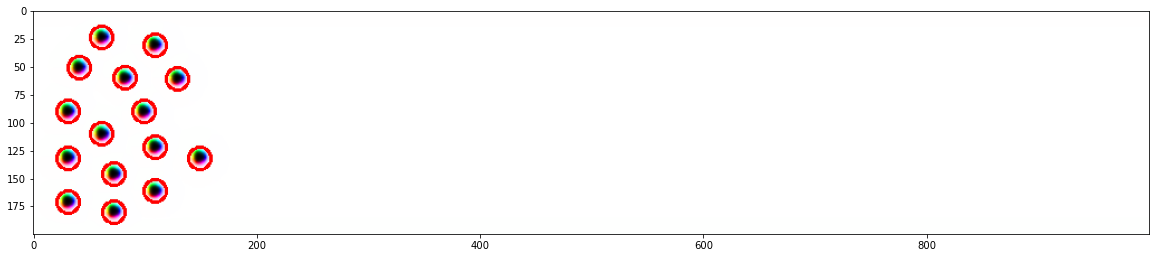

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 119.29it/s]


In [163]:
# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data, directory)

# format data so that it is in the format (frame, next_frame)
frames = np.array(get_frames(data_scaled))

# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

In [164]:
# split into train and test sets
train_size = int(len(frames) * 0.67)
test_size = len(frames) - train_size
train, test = frames[0:train_size,:], frames[train_size:len(frames),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [165]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [166]:
# choose a number of time steps
n_steps = 5
# convert into input/output
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [167]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

In [168]:
# define model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(SimpleRNN(128, activation='relu', return_sequences=True))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [169]:
# fit model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=400)

Train on 531 samples, validate on 259 samples
Epoch 1/400
531/531 [==============================] - 1s 953us/step - loss: 0.1153 - val_loss: 0.1073
Epoch 2/400
531/531 [==============================] - 0s 218us/step - loss: 0.0122 - val_loss: 0.0672
Epoch 3/400
531/531 [==============================] - 0s 199us/step - loss: 0.0046 - val_loss: 0.0494
Epoch 4/400
531/531 [==============================] - 0s 193us/step - loss: 0.0025 - val_loss: 0.0400
Epoch 5/400
531/531 [==============================] - 0s 193us/step - loss: 0.0019 - val_loss: 0.0357
Epoch 6/400
531/531 [==============================] - 0s 199us/step - loss: 0.0016 - val_loss: 0.0353
Epoch 7/400
531/531 [==============================] - 0s 185us/step - loss: 0.0014 - val_loss: 0.0349
Epoch 8/400
531/531 [==============================] - 0s 185us/step - loss: 0.0012 - val_loss: 0.0328
Epoch 9/400
531/531 [==============================] - 0s 197us/step - loss: 0.0011 - val_loss: 0.0307
Epoch 10/400
531/531 [=====

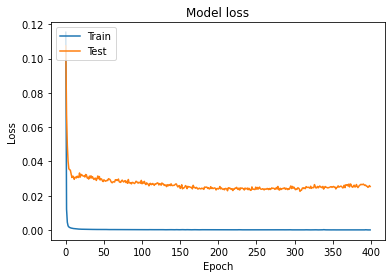

In [170]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [ ]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

pred_train = min_max_scaler.inverse_transform(pred_train)
pred_test = min_max_scaler.inverse_transform(pred_test)

In [ ]:
pred_train_df = get_predictions_df(pred_train)
pred_test_df = get_predictions_df(pred_test)

In [ ]:
plot_prediction(data, pred_test_df, pred_train_df, ids=[0])